# MLFlow Experiment (Papermill)

- The source notebook: `mlflow_experiment.ipynb`
- Generated notebooks: `papermill_runs/`

## Run experiments

In [1]:
from pathlib import Path
from itertools import product
from tqdm import tqdm
import papermill as pm

In [2]:
nb_source = 'mlflow_experiment.ipynb'
nb_pm_dir = 'papermill_runs'

params = dict(
    include_c=[True, False],
    adjust_for_country=[True, False],
)

In [3]:
params_product = [dict(zip(params, v)) for v in product(*params.values())]
for d in tqdm(params_product):
    print(d)
    nb_pm_fname = 'pm__' + '_'.join(f'{k}={v}' for k, v in d.items()) + '.ipynb'
#     nb_pm = Path(nb_pm_dir) / f'test.ipynb'
    _ = pm.execute_notebook(nb_source, Path(nb_pm_dir) / nb_pm_fname, parameters=d, progress_bar=False)

  0%|          | 0/4 [00:00<?, ?it/s]

{'include_c': True, 'adjust_for_country': True}


 25%|██▌       | 1/4 [00:06<00:18,  6.09s/it]

{'include_c': True, 'adjust_for_country': False}


 50%|█████     | 2/4 [00:09<00:10,  5.43s/it]

{'include_c': False, 'adjust_for_country': True}


 75%|███████▌  | 3/4 [00:11<00:04,  4.40s/it]

{'include_c': False, 'adjust_for_country': False}


100%|██████████| 4/4 [00:13<00:00,  3.45s/it]


## Make a summary

In [4]:
import pandas as pd
import sqlite3
from dutil.jupyter import dht
from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns

plt.rcParams['font.family'] = 'monospace'
plt.style.use('seaborn')

In [5]:
def query_mlruns(query: str, query_args = tuple()) -> pd.DataFrame:
    with sqlite3.connect('mlruns.db') as conn:
        c = conn.cursor()
        records = c.execute(query, query_args).fetchall()
        columns = [x[0] for x in c.description]
    df = pd.DataFrame(records, columns = columns)
    return df

In [7]:
display(query_mlruns("""select name from sqlite_master where type='table'"""))
display(query_mlruns("""select * from experiments"""))


,name
0,experiments
1,params
2,alembic_version
3,metrics
4,experiment_tags
5,tags
6,latest_metrics
7,registered_models
8,model_versions
9,runs


,experiment_id,name,artifact_location,lifecycle_stage
0,0,Default,./mlruns/0,active
1,1,mlpipe_,./mlruns/1,active


In [9]:
runs = query_mlruns("""select * from runs""")
metrics = query_mlruns("""select * from metrics""")
params = query_mlruns("""select * from params""")
dht(runs, 1)
dht(metrics, 1)
dht(params, 1)

,run_uuid,name,source_type,source_name,entry_point_name,user_id,status,start_time,end_time,source_version,lifecycle_stage,artifact_uri,experiment_id
0,4230137cb65e4aa39ced162ca4861029,,UNKNOWN,,,nameless,FINISHED,1608296705051,1608296705268,,active,./mlruns/1/4230137cb65e4aa39ced162ca4861029/ar...,1
3,cf1ed9d6a1e6466bb4fa701d04185b22,,UNKNOWN,,,nameless,FINISHED,1608296710417,1608296710563,,active,./mlruns/1/cf1ed9d6a1e6466bb4fa701d04185b22/ar...,1


,key,value,timestamp,run_uuid,step,is_nan
0,test_mae,-2.833333,1608296705187,4230137cb65e4aa39ced162ca4861029,0,0
15,train_r2,0.727900,1608296710506,cf1ed9d6a1e6466bb4fa701d04185b22,0,0


,key,value,run_uuid
0,fversion,0,4230137cb65e4aa39ced162ca4861029
31,model_name,rf,cf1ed9d6a1e6466bb4fa701d04185b22


In [11]:
ids_ = set(runs.loc[runs['experiment_id'] == 1, 'run_uuid'])
metrics_ = metrics.loc[metrics['run_uuid'].isin(ids_)].reset_index(drop=True)
metrics_ = pd.pivot(metrics_, index='run_uuid', columns='key', values='value')
params_ = params.loc[params['run_uuid'].isin(ids_)].reset_index(drop=True)
params_ = pd.pivot(params_, index='run_uuid', columns='key', values='value')

dht(metrics_, 1)
dht(params_, 1)

key,test_mae,test_r2,train_mae,train_r2
run_uuid,,,,
3132a2ef9808425da5b9cfcfdbd709b7,-1.575,-5.30125,-0.3825,0.7298
cf1ed9d6a1e6466bb4fa701d04185b22,-1.640,-6.00080,-0.3700,0.7279


key,adjust_for_country,fversion,include_country,model_name,mversion,n_folds,target,test_ratio
run_uuid,,,,,,,,
3132a2ef9808425da5b9cfcfdbd709b7,True,0,True,rf,0,2,e,0.3
cf1ed9d6a1e6466bb4fa701d04185b22,False,0,True,rf,0,2,e,0.3


Filtered runs: 4 / 4


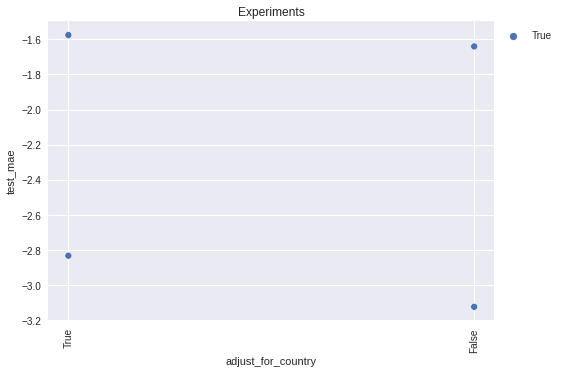

In [25]:
def plot_summary(
    params_df, 
    metrics_df,
    filter_query,
    param_x,
    param_hue,
    metric_y,
    title='Experiments',
    xticks_rotation=90,
):
    if (filter_query is not None) and (len(filter_query) > 0):
        params_df = params_df.query(filter_query)
    df = params_df[[param_x, param_hue]].join(metrics_df[[metric_y]], how='inner')
    print("Filtered runs: {} / {}".format(len(df), len(params_df)))
    sns.scatterplot(data=df, x=param_x, y=metric_y, hue=param_hue)
    plt.title(title)
    plt.legend(loc='upper left',  bbox_to_anchor=(1., 1.))
    plt.xticks(rotation=xticks_rotation)
    
plot_summary(
    params_, metrics_, 
    "fversion == '0'", 
    'adjust_for_country', 'include_country', 'test_mae',
)